# PyTorch Image Captioning model for time series 

This notebook demonstrates how to use an image-captioning model for time-series prediction.  The data set is based on the NASDAQ 100 data provided in "[A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction](https://arxiv.org/pdf/1704.02971.pdf)".

The code reuses the same sampling code from Chandler Zuo's [blog](http://chandlerzuo.github.io/blog/2017/11/darnn).

The image captioning model was based off of the following PyTorch [tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning) on image captioning.

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import matplotlib
# matplotlib.use('Agg')
%matplotlib notebook

import os
import datetime as dt
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

use_cuda = torch.cuda.is_available()
# use_cuda = False
print("Is CUDA available? ", use_cuda)

Is CUDA available?  True


### Logger set up

In [2]:
import logging

modelName = "cnn_lstm"

# check if results directory exists
if not os.path.isdir("./results/%s" %(modelName)):
    os.makedirs("./results/%s" %(modelName))

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
dlogger = logging.getLogger(__name__)
dlogger.setLevel(logging.DEBUG)

# create file handler
log = logging.FileHandler("./results/%s/%s_results.log" %(modelName, modelName))
log.setLevel(logging.INFO)
debug_log = logging.FileHandler("./results/%s/%s_debug.log" %(modelName, modelName))
debug_log.setLevel(logging.DEBUG)

logger.addHandler(log)
dlogger.addHandler(debug_log)

### Encoder: CNN

In [3]:
class EncoderCNN(nn.Module):
    def __init__(self, input_dim=1, channel_size=64, batch_size=10, T=100, feature_size=81):
        super(EncoderCNN, self).__init__()
        self.input_dim = input_dim    # num channels
        self.batch_size = batch_size
        self.channel_size = channel_size
        self.T = T
        self.feature_size = feature_size
        # (N, C, H, W) = (num_batch, features, history, stocks)
        # Conv2d - out:(N, 64, 100, 81), kernel(3, 5) stride:1
        
        # added a linear layer to shrink the num stocks lower due to memory 
        self.small_feature_size = 10
        self.first_linear = nn.Linear(feature_size, self.small_feature_size)
        
        self.first_cnn_layer = nn.Sequential(
            nn.Conv2d(input_dim, channel_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2))
        
        # Conv2d - out:(N, 64, 100, 81), kernel(3,5) stride:1
        self.second_cnn_layer = nn.Sequential(
            nn.Conv2d(channel_size, channel_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2))

        # dense layer - in: (N, 100*64*81), out: (N, 100*81)
        self.first_dense_layer = nn.Sequential(
            nn.Linear(T*self.small_feature_size*channel_size, T*self.feature_size),
            nn.ReLU(),
            nn.Dropout(0.2))

    
    def forward(self, xt):
        # conv2d input (N, 1, H, W) expects (N, C, H, W) 
#         print("x: ", xt.size())
        N = xt.size(0)
        
        # lin: in (N, 1, H, W) out: (N, 1, H, 10)
        out = self.first_linear(xt)
#         print("cnn: linear: ", out.size())
        
        # cnn: in (N, 1, H, 10) out: (N, C, H, 10)
        out = self.first_cnn_layer(out)
#         print("cnn: first_layer output: ", out.size())

        # cnn: in (N, C, H, 10) out: (N, C, H, 10)
        out = self.second_cnn_layer(out)
#         print("cnn: second_layer output: ", out.size())

        # reshape for linear layer
        out = out.view(N, self.T*self.small_feature_size*self.channel_size)
#         print("flatten: ", out.size())

        # first dense layer in: (N, C*H*W) out: (N, H*W)
        out = self.first_dense_layer(out)
#         print("first dense layer output: ", out.size())
        
        # reshape output for (N, T, W)
        out = out.reshape(out.size(0), self.T, self.feature_size)
#         print("reshape out: ", out.size())

        return out

### Decoder: LSTM

In [4]:
class DecoderLSTM(nn.Module):
    def __init__(self, feature_size, decoder_hidden_size, T=100, num_layers=2):
        super(DecoderLSTM, self).__init__()

        self.T = T
        self.feature_size = feature_size
        self.decoder_hidden_size = decoder_hidden_size
#         print("decoder: decoder_hidden_size: ", decoder_hidden_size)
        
        # lstm - in: (N, T, W) out: (N, T, H)
        self.lstm_layer = nn.LSTM(feature_size, decoder_hidden_size, 
                                  num_layers=num_layers,
                                  dropout=0.2, 
                                  batch_first=True)
        # dense layer - in: (N, T*H), out: (N, T*H)
        self.dense_layer = nn.Sequential(
            nn.Linear(T*(decoder_hidden_size+1), T*(decoder_hidden_size+1)),
            nn.ReLU(),
            nn.Dropout(0.2))
        # final layer - in: (N, T*H) out:(N, 1)
        self.final_layer = nn.Linear(T*(decoder_hidden_size+1), 1)

        # log info
        logger.info("decoder - feature_size: %s hidden_size: %s T: %s" \
                    %(feature_size, decoder_hidden_size, T))
        
    def forward(self, features, y_history):
        
        # x (N, T, W) y_history (N, T, 1)
#         print("features: ", features.size())
#         print("y_history: ", y_history.size())
  
        # lstm layer in: (N, T, W) out: (N, T, H)
        out, lstm_out = self.lstm_layer(features)
#         print("lstm layer: ", out.size())
    
        # clipping to eliminate nan's from lstm
        out.register_hook(lambda x: x.clamp(min=-100, max=100))
        
        # combine with y_history
        out = torch.cat((out, y_history), dim=2)
#         print("out cat: ", out.size())
        
        # flatten in: (N, T, H) out: (N, T*(H=1))
        out = out.contiguous().view(-1, out.size(1)*out.size(2))
#         print("out flatten: ", out.size())
               
        # final layer in: (N, T*(H+1)), out: (N, 1)
        out = self.final_layer(out)
#         print("final layer: ", out.size())
        
        return out

    def init_hidden(self, x):
        return Variable(x.data.new(1, x.size(0), self.decoder_hidden_size).zero_())

### Train & Test

In [5]:
# Train the model
class cnn_lstm:
    def __init__(self, file_data, decoder_hidden_size = 64, T = 10,
                 input_dim= 1, channel_size = 64, feature_size = 81,
                 learning_rate = 0.01, batch_size = 128, parallel = False, debug = False):
        self.T = T
        dat = pd.read_csv(file_data, nrows = 100 if debug else None)
        print("Shape of data: %s.\nMissing in data: %s" %(dat.shape, dat.isnull().sum().sum()))

        self.X = dat[[x for x in dat.columns if x != 'NDX']][:-1].as_matrix()
        # drop last row since using forward y
        y = dat.NDX.shift(-1).values
        self.y = y[:-1].reshape((-1, 1))
        
        print("X shape", self.X.shape)
        print("y shape", self.y.shape)
        
        self.batch_size = batch_size

        if use_cuda: 
            #input_dim=1, channel_size=64, batch_size=10, T=100, feature_size=81)
            self.encoder = EncoderCNN(input_dim=input_dim, channel_size=channel_size,
                                     batch_size=batch_size, T=T, feature_size=feature_size).cuda()
            # feature_size, decoder_hidden_size, T=100, num_layers=2)
            self.decoder = DecoderLSTM(feature_size, decoder_hidden_size, T=T, num_layers=2).cuda()

        else:
            self.encoder = EncoderCNN(input_dim=input_dim, channel_size=channel_size,
                                     batch_size=batch_size, T=T, feature_size=feature_size).cpu()
            self.decoder = DecoderLSTM(feature_size, decoder_hidden_size, T=T, num_layers=2).cpu()


        if parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.encoder.parameters()),
                                           lr = learning_rate)
        self.decoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.decoder.parameters()),
                                           lr = learning_rate)

        self.train_size = int(self.X.shape[0] * 0.7)
        self.train_mean = np.mean(self.y[:self.train_size])
        print("train mean: %s" %(self.train_mean))
        self.y = self.y - self.train_mean # Question: why Adam requires data to be normalized?
        print("Training size: %s" %(self.train_size))
        logger.info("Training size: %s" %(self.train_size))

    def train(self, n_epochs = 10):
        iter_per_epoch = int(np.ceil(self.train_size * 1. / self.batch_size))
        print("Iterations per epoch: %s ~ %s" %(self.train_size * 1. / self.batch_size, iter_per_epoch))
        logger.info("Iterations per epoch: %s ~ %s" %(self.train_size * 1. / self.batch_size, iter_per_epoch))
        self.iter_losses = np.zeros(n_epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(n_epochs)

        self.loss_func = nn.MSELoss()

        n_iter = 0

        learning_rate = 1.

        for i in range(n_epochs):
            print("\n-------------------------------------------")
            print("Epoch: ", i)
            logger.info("\n-------------------------------------------")
            logger.info("Epoch: %s" %(i))
            perm_idx = np.random.permutation(self.train_size - self.T)
            j = 0
            while j < self.train_size - self.T:
                batch_idx = perm_idx[j:(j + self.batch_size)]
                X = np.zeros((len(batch_idx), self.T, self.X.shape[1]))
                y_history = np.zeros((len(batch_idx), self.T))
                y_target = self.y[batch_idx + self.T]

                for k in range(len(batch_idx)):
                    X[k, :, :] = self.X[batch_idx[k] : (batch_idx[k] + self.T), :]
                    # y_history[k, :] (T-1,)
                    y_history[k, :] = self.y[batch_idx[k] : (batch_idx[k] + self.T)].flatten()

                # train
                loss = self.train_iteration(X, y_history, y_target)
#                 print("loss: ", loss.item())

                self.iter_losses[int(i * iter_per_epoch + j / self.batch_size)] = loss
                if (j / self.batch_size) % 50 == 0:
                    print("\tbatch: %s  loss: %s" %(j / self.batch_size, loss))
                    logger.info("\tbatch: %s  loss: %s" %(j / self.batch_size, loss))
                
                j += self.batch_size
                n_iter += 1

                # decrease learplt.savefig("./results/%s/predi")plt.savefig("./results/%s/predi")ning rate
                if n_iter % 10000 == 0 and n_iter > 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    logger.info("encoder learning rate: ", param_group["lr"])
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    logger.info("decoder learning rate: ", param_group["lr"])

                    
            self.epoch_losses[i] = np.mean(self.iter_losses[range(i * iter_per_epoch, (i + 1) * iter_per_epoch)])
            if i % 10 == 0:
                print("Epoch %s, loss: %s" %(i, self.epoch_losses[i]))
                logger.info("Epoch %s, loss: %s" %(i, self.epoch_losses[i]))
                
            if i % 10 == 0:
                print("\n Predict")
                y_train_pred = self.predict(on_train = True)
                y_test_pred = self.predict(on_train = False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                y_pred = y_train_pred
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label = "True")
                plt.plot(range(self.T , len(y_train_pred) + self.T), y_train_pred, label = 'Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred) , len(self.y) + 1), y_test_pred, label = 'Predicted - Test')
                plt.legend(loc = 'upper left')
                plt.show()
                plt.savefig("./results/%s/predict_%s_epoch%s.png" %(modelName, modelName, i), bbox_inches="tight")

    def train_iteration(self, X, y_history, y_target):

        # zero gradient - original code placemenet
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        
        # define variables
        if use_cuda:       
            Xt = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda())
            yht = Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda())
            y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor).cuda())            
        else:
            Xt = Variable(torch.from_numpy(X).type(torch.FloatTensor).cpu())
            yht = Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cpu())
            y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor).cpu())
        

        # run models get prediction
        # Xt (N, C, H, W)
        Xt = Xt.view(Xt.size(0), 1, Xt.size(1), Xt.size(2))
        # yht (N, T, 1)
        yht = yht.unsqueeze(2)
        features = self.encoder(Xt)
        y_pred = self.decoder(features, yht)
        
        # loss 
        loss = self.loss_func(y_pred, y_true)
        loss.backward()
        
        # optimizer
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()

    def predict(self, on_train = False):
        
        
        if on_train:
            y_pred = np.zeros(self.train_size - self.T + 1)
            print("PREDICT train")
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_size)
            print("PREDICT test")

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T))


            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(batch_idx[j], batch_idx[j] + self.T), :]
                    y_history[j, :] = self.y[range(batch_idx[j],  batch_idx[j]+ self.T)].flatten()
                else:
                    X[j, :, :] = self.X[range(batch_idx[j] + self.train_size - self.T, batch_idx[j] + self.train_size), :]
                    y_history[j, :] = self.y[range(batch_idx[j] + self.train_size - self.T,  batch_idx[j]+ self.train_size)].flatten()
            
            if use_cuda:
                Xt = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda())
                yht = Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda())
                # Xt (N, C, H, W)
                Xt = Xt.view(Xt.size(0), 1, Xt.size(1), Xt.size(2))
                # yht (N, T, 1)
                yht = yht.unsqueeze(2)
                features = self.encoder(Xt)
                pred_cuda = self.decoder(features, yht)
                y_pred[i:(i+self.batch_size)] = pred_cuda.cpu().data.numpy()[:, 0]
            else:
                Xt = Variable(torch.from_numpy(X).type(torch.FloatTensor).cpu())
                yht = Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cpu())
                # Xt (N, C, H, W)
                Xt = Xt.view(Xt.size(0), 1, Xt.size(1), Xt.size(2))
                # yht (N, T, 1)
                yht = yht.unsqueeze(2)
                features = self.encoder(Xt)        
                y_pred[i:(i + self.batch_size)] = self.decoder(features, yht).data.numpy()[:, 0]           
            
            i += self.batch_size
        
        return y_pred


In [6]:
index_file = "./nasdaq100/small/nasdaq100_padding.csv"

#                  file_data, decoder_hidden_size = 64, T = 10,
#                  input_dim= 1, channel_size = 64, feature_size = 81,
#                  learning_rate = 0.01, batch_size = 128, parallel = False, debug = False)
model = cnn_lstm(file_data=index_file, decoder_hidden_size = 100, T = 50,
                 input_dim = 1, channel_size = 64, feature_size = 81,
                 learning_rate = 0.01, batch_size = 128, parallel = False, debug = False)


model.train(n_epochs = 100)

y_train = model.predict(on_train=True)
y_pred = model.predict(on_train=False)

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()
plt.savefig("./results/%s/iter_losses_%s.png" %(modelName, modelName), bbox_inches="tight")

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()
plt.savefig("./results/%s/epoch_losses_%s.png" %(modelName, modelName), bbox_inches="tight")


Shape of data: (40560, 82).
Missing in data: 0
X shape (40559, 81)
y shape (40559, 1)
train mean: 4803.5943792
Training size: 28391
Iterations per epoch: 221.8046875 ~ 222

-------------------------------------------
Epoch:  0
	batch: 0.0  loss: 2684.357177734375
	batch: 50.0  loss: 39.432098388671875
	batch: 100.0  loss: 19.076492309570312
	batch: 150.0  loss: 22.352664947509766
	batch: 200.0  loss: 7.961240768432617
Epoch 0, loss: 63.1004921853

 Predict
PREDICT train
PREDICT test


<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  1
	batch: 0.0  loss: 10.15947437286377
	batch: 50.0  loss: 14.579567909240723
	batch: 100.0  loss: 7.355172634124756
	batch: 150.0  loss: 7.675591468811035
	batch: 200.0  loss: 8.936471939086914

-------------------------------------------
Epoch:  2
	batch: 0.0  loss: 8.777327537536621
	batch: 50.0  loss: 4.366830348968506
	batch: 100.0  loss: 4.249478340148926
	batch: 150.0  loss: 2.786012887954712
	batch: 200.0  loss: 9.523365020751953

-------------------------------------------
Epoch:  3
	batch: 0.0  loss: 4.5287275314331055
	batch: 50.0  loss: 2.9262890815734863
	batch: 100.0  loss: 8.066276550292969
	batch: 150.0  loss: 3.920835018157959
	batch: 200.0  loss: 2.7085652351379395

-------------------------------------------
Epoch:  4
	batch: 0.0  loss: 3.665313243865967
	batch: 50.0  loss: 4.7164692878723145
	batch: 100.0  loss: 3.002876043319702
	batch: 150.0  loss: 3.0717484951019287
	batch: 200.0  loss: 2.651467800140381

-----

<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  11
	batch: 0.0  loss: 4.37379264831543
	batch: 50.0  loss: 1.8429582118988037
	batch: 100.0  loss: 6.234961032867432
	batch: 150.0  loss: 3.4232029914855957
	batch: 200.0  loss: 1.7301955223083496

-------------------------------------------
Epoch:  12
	batch: 0.0  loss: 3.068836212158203
	batch: 50.0  loss: 6.531868934631348
	batch: 100.0  loss: 2.732870578765869
	batch: 150.0  loss: 2.1728944778442383
	batch: 200.0  loss: 2.3202948570251465

-------------------------------------------
Epoch:  13
	batch: 0.0  loss: 1.7370693683624268
	batch: 50.0  loss: 2.1828107833862305
	batch: 100.0  loss: 11.45292854309082
	batch: 150.0  loss: 2.207871913909912
	batch: 200.0  loss: 2.8262758255004883

-------------------------------------------
Epoch:  14
	batch: 0.0  loss: 2.705575942993164
	batch: 50.0  loss: 3.9742136001586914
	batch: 100.0  loss: 2.228109359741211
	batch: 150.0  loss: 2.0106325149536133
	batch: 200.0  loss: 3.835492610931396

<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  21
	batch: 0.0  loss: 3.843843698501587
	batch: 50.0  loss: 2.315425395965576
	batch: 100.0  loss: 1.6679182052612305
	batch: 150.0  loss: 3.426283836364746
	batch: 200.0  loss: 1.2946345806121826

-------------------------------------------
Epoch:  22
	batch: 0.0  loss: 2.3438072204589844
	batch: 50.0  loss: 2.1860103607177734
	batch: 100.0  loss: 3.116816520690918
	batch: 150.0  loss: 2.247305393218994
	batch: 200.0  loss: 1.5351264476776123

-------------------------------------------
Epoch:  23
	batch: 0.0  loss: 2.343527317047119
	batch: 50.0  loss: 1.8468914031982422
	batch: 100.0  loss: 1.881842017173767
	batch: 150.0  loss: 2.6298582553863525
	batch: 200.0  loss: 7.172685623168945

-------------------------------------------
Epoch:  24
	batch: 0.0  loss: 2.100320816040039
	batch: 50.0  loss: 1.779325246810913
	batch: 100.0  loss: 2.516937494277954
	batch: 150.0  loss: 2.5348172187805176
	batch: 200.0  loss: 4.630214691162109


<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  31
	batch: 0.0  loss: 23.601823806762695
	batch: 50.0  loss: 2.535465717315674
	batch: 100.0  loss: 2.2853195667266846
	batch: 150.0  loss: 3.395375967025757
	batch: 200.0  loss: 2.9982433319091797

-------------------------------------------
Epoch:  32
	batch: 0.0  loss: 2.2810816764831543
	batch: 50.0  loss: 6.5649261474609375
	batch: 100.0  loss: 2.0767688751220703
	batch: 150.0  loss: 5.664480209350586
	batch: 200.0  loss: 3.7343835830688477

-------------------------------------------
Epoch:  33
	batch: 0.0  loss: 1.1894166469573975
	batch: 50.0  loss: 11.259636878967285
	batch: 100.0  loss: 1.1791629791259766
	batch: 150.0  loss: 3.6330626010894775
	batch: 200.0  loss: 2.2051618099212646

-------------------------------------------
Epoch:  34
	batch: 0.0  loss: 1.8956198692321777
	batch: 50.0  loss: 11.73097038269043
	batch: 100.0  loss: 2.5685410499572754
	batch: 150.0  loss: 1.4776140451431274
	batch: 200.0  loss: 2.263620376

<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  41
	batch: 0.0  loss: 4.4203081130981445
	batch: 50.0  loss: 3.633251428604126
	batch: 100.0  loss: 5.74388313293457
	batch: 150.0  loss: 12.908236503601074
	batch: 200.0  loss: 1.7921767234802246

-------------------------------------------
Epoch:  42
	batch: 0.0  loss: 1.3410853147506714
	batch: 50.0  loss: 3.5581440925598145
	batch: 100.0  loss: 4.73465633392334
	batch: 150.0  loss: 2.516463041305542
	batch: 200.0  loss: 1.6619601249694824

-------------------------------------------
Epoch:  43
	batch: 0.0  loss: 7.130738258361816
	batch: 50.0  loss: 3.7956454753875732
	batch: 100.0  loss: 24.848669052124023
	batch: 150.0  loss: 2.3979015350341797
	batch: 200.0  loss: 2.036526679992676

-------------------------------------------
Epoch:  44
	batch: 0.0  loss: 2.5107297897338867
	batch: 50.0  loss: 2.0202012062072754
	batch: 100.0  loss: 1.838209867477417
	batch: 150.0  loss: 1.73600172996521
	batch: 200.0  loss: 1.6681175231933594

--- Logging error ---
Traceback (most recent call last):
  File "/home/tesa/anaconda3/lib/python3.6/logging/__init__.py", line 987, in emit
    msg = self.format(record)
  File "/home/tesa/anaconda3/lib/python3.6/logging/__init__.py", line 833, in format
    return fmt.format(record)
  File "/home/tesa/anaconda3/lib/python3.6/logging/__init__.py", line 570, in format
    record.message = record.getMessage()
  File "/home/tesa/anaconda3/lib/python3.6/logging/__init__.py", line 333, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/tesa/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tesa/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tesa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tesa/anaconda3/lib/python3.6/site-p

	batch: 50.0  loss: 4.257923126220703
	batch: 100.0  loss: 19.796302795410156
	batch: 150.0  loss: 1.4788691997528076
	batch: 200.0  loss: 1.9763250350952148

-------------------------------------------
Epoch:  46
	batch: 0.0  loss: 1.6074354648590088
	batch: 50.0  loss: 2.2414779663085938
	batch: 100.0  loss: 2.790677309036255
	batch: 150.0  loss: 3.6631698608398438
	batch: 200.0  loss: 6.4405317306518555

-------------------------------------------
Epoch:  47
	batch: 0.0  loss: 7.386512756347656
	batch: 50.0  loss: 4.3874006271362305
	batch: 100.0  loss: 1.9109926223754883
	batch: 150.0  loss: 9.667684555053711
	batch: 200.0  loss: 1.6592233180999756

-------------------------------------------
Epoch:  48
	batch: 0.0  loss: 1.541727066040039
	batch: 50.0  loss: 1.5165454149246216
	batch: 100.0  loss: 1.3131208419799805
	batch: 150.0  loss: 0.8916535377502441
	batch: 200.0  loss: 1.78054940700531

-------------------------------------------
Epoch:  49
	batch: 0.0  loss: 1.767431616783

<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  51
	batch: 0.0  loss: 1.0590596199035645
	batch: 50.0  loss: 1.4744845628738403
	batch: 100.0  loss: 2.7148025035858154
	batch: 150.0  loss: 2.331416368484497
	batch: 200.0  loss: 1.223453402519226

-------------------------------------------
Epoch:  52
	batch: 0.0  loss: 1.7897449731826782
	batch: 50.0  loss: 3.1142683029174805
	batch: 100.0  loss: 3.258152484893799
	batch: 150.0  loss: 1.263515830039978
	batch: 200.0  loss: 3.059750556945801

-------------------------------------------
Epoch:  53
	batch: 0.0  loss: 0.9474451541900635
	batch: 50.0  loss: 1.557315707206726
	batch: 100.0  loss: 2.5492918491363525
	batch: 150.0  loss: 2.2472541332244873
	batch: 200.0  loss: 7.298044204711914

-------------------------------------------
Epoch:  54
	batch: 0.0  loss: 1.565929889678955
	batch: 50.0  loss: 3.437546730041504
	batch: 100.0  loss: 3.4027328491210938
	batch: 150.0  loss: 1.8593401908874512
	batch: 200.0  loss: 1.98397696018219

<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  61
	batch: 0.0  loss: 1.1115763187408447
	batch: 50.0  loss: 18.16586685180664
	batch: 100.0  loss: 2.9480819702148438
	batch: 150.0  loss: 3.183067798614502
	batch: 200.0  loss: 3.3178822994232178

-------------------------------------------
Epoch:  62
	batch: 0.0  loss: 0.9285914897918701
	batch: 50.0  loss: 2.267798900604248
	batch: 100.0  loss: 2.2501416206359863
	batch: 150.0  loss: 1.0975350141525269
	batch: 200.0  loss: 1.4458414316177368

-------------------------------------------
Epoch:  63
	batch: 0.0  loss: 2.7325546741485596
	batch: 50.0  loss: 2.1104938983917236
	batch: 100.0  loss: 2.7801733016967773
	batch: 150.0  loss: 2.40525484085083
	batch: 200.0  loss: 6.560671806335449

-------------------------------------------
Epoch:  64
	batch: 0.0  loss: 4.481457233428955
	batch: 50.0  loss: 3.0652074813842773
	batch: 100.0  loss: 1.6650017499923706
	batch: 150.0  loss: 2.4635047912597656
	batch: 200.0  loss: 3.455059528350

<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  71
	batch: 0.0  loss: 3.280263900756836
	batch: 50.0  loss: 1.5668697357177734
	batch: 100.0  loss: 1.9312711954116821
	batch: 150.0  loss: 1.0009652376174927
	batch: 200.0  loss: 2.2794785499572754

-------------------------------------------
Epoch:  72
	batch: 0.0  loss: 3.5165750980377197
	batch: 50.0  loss: 2.372389316558838
	batch: 100.0  loss: 0.8241671323776245
	batch: 150.0  loss: 2.6359634399414062
	batch: 200.0  loss: 5.03023624420166

-------------------------------------------
Epoch:  73
	batch: 0.0  loss: 1.3810536861419678
	batch: 50.0  loss: 7.213955879211426
	batch: 100.0  loss: 1.4922685623168945
	batch: 150.0  loss: 1.597625970840454
	batch: 200.0  loss: 3.18449330329895

-------------------------------------------
Epoch:  74
	batch: 0.0  loss: 13.670222282409668
	batch: 50.0  loss: 2.1351065635681152
	batch: 100.0  loss: 2.1372580528259277
	batch: 150.0  loss: 3.5712053775787354
	batch: 200.0  loss: 15.167689323425

<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  81
	batch: 0.0  loss: 6.696502685546875
	batch: 50.0  loss: 1.4192886352539062
	batch: 100.0  loss: 3.6796836853027344
	batch: 150.0  loss: 1.0844355821609497
	batch: 200.0  loss: 1.6786092519760132

-------------------------------------------
Epoch:  82
	batch: 0.0  loss: 3.8677186965942383
	batch: 50.0  loss: 1.7855422496795654
	batch: 100.0  loss: 2.6492905616760254
	batch: 150.0  loss: 6.486734390258789
	batch: 200.0  loss: 1.4519755840301514

-------------------------------------------
Epoch:  83
	batch: 0.0  loss: 1.3047279119491577
	batch: 50.0  loss: 3.595322608947754
	batch: 100.0  loss: 1.8538498878479004
	batch: 150.0  loss: 1.5298947095870972
	batch: 200.0  loss: 1.4420788288116455

-------------------------------------------
Epoch:  84
	batch: 0.0  loss: 1.379431128501892
	batch: 50.0  loss: 2.0923471450805664
	batch: 100.0  loss: 1.4347264766693115
	batch: 150.0  loss: 1.9934474229812622
	batch: 200.0  loss: 1.354613542

--- Logging error ---
Traceback (most recent call last):
  File "/home/tesa/anaconda3/lib/python3.6/logging/__init__.py", line 987, in emit
    msg = self.format(record)
  File "/home/tesa/anaconda3/lib/python3.6/logging/__init__.py", line 833, in format
    return fmt.format(record)
  File "/home/tesa/anaconda3/lib/python3.6/logging/__init__.py", line 570, in format
    record.message = record.getMessage()
  File "/home/tesa/anaconda3/lib/python3.6/logging/__init__.py", line 333, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/tesa/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tesa/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tesa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tesa/anaconda3/lib/python3.6/site-p

	batch: 50.0  loss: 2.1969242095947266
	batch: 100.0  loss: 1.2816808223724365
	batch: 150.0  loss: 8.547122955322266
	batch: 200.0  loss: 7.169300079345703
Epoch 90, loss: 2.80751393319

 Predict
PREDICT train
PREDICT test


<IPython.core.display.Javascript object>


-------------------------------------------
Epoch:  91
	batch: 0.0  loss: 2.3599464893341064
	batch: 50.0  loss: 6.390711784362793
	batch: 100.0  loss: 1.8959286212921143
	batch: 150.0  loss: 1.5996016263961792
	batch: 200.0  loss: 2.3648829460144043

-------------------------------------------
Epoch:  92
	batch: 0.0  loss: 1.95664644241333
	batch: 50.0  loss: 3.005692481994629
	batch: 100.0  loss: 1.7601147890090942
	batch: 150.0  loss: 2.038790464401245
	batch: 200.0  loss: 0.9683154225349426

-------------------------------------------
Epoch:  93
	batch: 0.0  loss: 1.8906534910202026
	batch: 50.0  loss: 2.7430977821350098
	batch: 100.0  loss: 2.1101837158203125
	batch: 150.0  loss: 1.422145962715149
	batch: 200.0  loss: 4.092895984649658

-------------------------------------------
Epoch:  94
	batch: 0.0  loss: 2.015176296234131
	batch: 50.0  loss: 2.5586323738098145
	batch: 100.0  loss: 8.148347854614258
	batch: 150.0  loss: 2.4975626468658447
	batch: 200.0  loss: 3.17764425277709

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


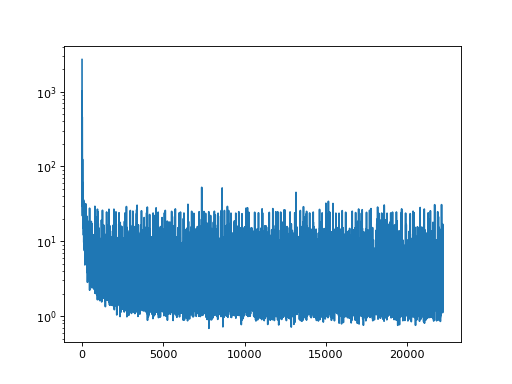

<IPython.core.display.Javascript object>


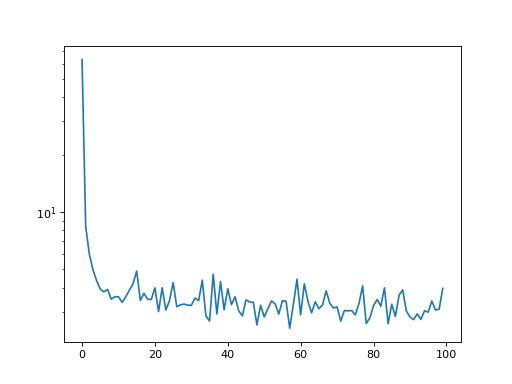

In [17]:
plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()
plt.savefig("./results/%s/iter_losses_%s.png" %(modelName, modelName), bbox_inches="tight")

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()
plt.savefig("./results/%s/epoch_losses_%s.png" %(modelName, modelName), bbox_inches="tight")

<IPython.core.display.Javascript object>


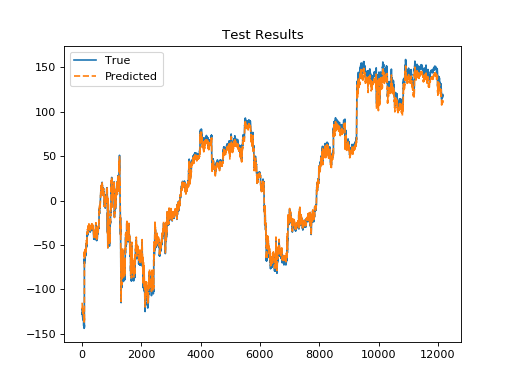

In [16]:
plt.figure()
plt.plot(model.y[model.train_size:], label = "True")
plt.plot(y_pred, label = 'Predicted', linestyle="--", )
plt.legend(loc = 'upper left')
plt.title("Test Results")
plt.show()
plt.savefig("./results/%s/predict_%s.png" %(modelName, modelName), bbox_inches="tight")

In [8]:

print("train_mean: ", model.train_mean)
y_true = model.y[model.train_size:].flatten() + model.train_mean
ydf = pd.DataFrame({"pred":y_pred + model.train_mean, "true":y_true})
ydf.to_csv("./results/%s/price_predictions_%s.csv" %(modelName, modelName))

train_mean:  4803.5943792


In [13]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ydf.true, ydf.pred)
print("average test mse: %s" %(mse))

average test mse: 21.452414252


In [14]:
y_train_true = model.y[:len(y_train)].flatten() + model.train_mean
ytrain_df = pd.DataFrame({"pred":y_train + model.train_mean, "true":y_train_true})
mse = mean_squared_error(ytrain_df.true, ytrain_df.pred)
print("average train mse: %s" %(mse))

average train mse: 126.889899904


In [15]:
# pre announcement
pre_mse = mean_squared_error(ydf.true.loc[:9259], ydf.pred.loc[:9259])
post_mse = mean_squared_error(ydf.true.loc[9259:], ydf.pred.loc[9259:])
print("pre_mse: %s" %(pre_mse))
print("post mse: %s" %(post_mse))

pre_mse: 12.238381283
post mse: 50.9216962104
